# Persist Benchmarks

In [197]:
# select measurement file
files = [
    "../output/2024-12-30 15-00-36 persist4.json",
]

# plot settings
show_error_bar = False
unit = "ms"
unit_joule = "mJ"


scale = 0.5

volt = 3.3
amps = 40e-3
wattage = volt * amps

print("Wattage:", wattage)

Wattage: 0.132


In [198]:
# parse data
import json

raw_data = []
for file_name in files:
    with open(file_name) as file:
        raw_data.extend(json.load(file))

In [199]:
from util.convert import convert_datasets
import pandas as pd

storage = convert_datasets(
    raw_data,
    "Storage",
    [("persistent_storage_write", "Storage Write")],
    ["mean", "min", "max", "options.object_size", "machine_name", "cold_start", "repetitions"],
    unwrapped=show_error_bar
)

baseline = convert_datasets(
    raw_data,
    "Persist",
    [("max_dirty_persist_latency_dirty_size", "Dirty Size"), ("max_dirty_persist_latency_buffer_size", "Buffer Size")],
    ["mean", "min", "max", "options.dirty_size", "options.buffer_size", "options.ram_overhead", "machine_name", "cold_start", "repetitions"],
    unwrapped=show_error_bar
)

dataset = pd.concat([storage, baseline])
dataset.head()

,mean,min,max,options.object_size,machine_name,cold_start,repetitions,ticks_per_ms,dataset_type,benchmark_title,benchmark_id,options.dirty_size,options.buffer_size,options.ram_overhead
0,318.4,312,376,0.0,esp32c3,0,10,16000,Storage,Storage Write,persistent_storage_write,NaN,NaN,NaN
1,6136.1,5615,10821,4.0,esp32c3,0,10,16000,Storage,Storage Write,persistent_storage_write,NaN,NaN,NaN
2,7404.8,6884,12089,8.0,esp32c3,0,10,16000,Storage,Storage Write,persistent_storage_write,NaN,NaN,NaN
3,8646.6,8126,13331,12.0,esp32c3,0,10,16000,Storage,Storage Write,persistent_storage_write,NaN,NaN,NaN
4,9888.8,9368,14573,16.0,esp32c3,0,10,16000,Storage,Storage Write,persistent_storage_write,NaN,NaN,NaN


In [200]:
# update the metrics in the following as we do not persist the datastructures of vNVHeaps explicitly in our benchmarks

ram_overhead = dataset.loc[(dataset["benchmark_id"] == "max_dirty_persist_latency_buffer_size") | (dataset["benchmark_id"] == "max_dirty_persist_latency_dirty_size"), "options.ram_overhead"]
assert(len(ram_overhead.unique()) == 1)
ram_overhead = ram_overhead.unique()[0]

# add the ram overhead to the buffer size and the dirty size (we want to include it to the RAM we manage and need to persist)
dataset.loc[(dataset["benchmark_id"] == "max_dirty_persist_latency_buffer_size") | (dataset["benchmark_id"] == "max_dirty_persist_latency_dirty_size"), "options.buffer_size"] += ram_overhead
dataset.loc[(dataset["benchmark_id"] == "max_dirty_persist_latency_buffer_size") | (dataset["benchmark_id"] == "max_dirty_persist_latency_dirty_size"), "options.dirty_size"] += ram_overhead

# add the latency it takes to persist the amount of bytes that is equal to the ram overhead
mean = dataset.loc[(dataset["benchmark_id"] == "persistent_storage_write") & (dataset["options.object_size"] == ram_overhead), "mean"].iloc[0]
min = dataset.loc[(dataset["benchmark_id"] == "persistent_storage_write") & (dataset["options.object_size"] == ram_overhead), "min"].iloc[0]
max = dataset.loc[(dataset["benchmark_id"] == "persistent_storage_write") & (dataset["options.object_size"] == ram_overhead), "max"].iloc[0]

dataset.loc[(dataset["benchmark_id"] == "max_dirty_persist_latency_buffer_size") | (dataset["benchmark_id"] == "max_dirty_persist_latency_dirty_size"), "mean"] += mean
dataset.loc[(dataset["benchmark_id"] == "max_dirty_persist_latency_buffer_size") | (dataset["benchmark_id"] == "max_dirty_persist_latency_dirty_size"), "min"] += min
dataset.loc[(dataset["benchmark_id"] == "max_dirty_persist_latency_buffer_size") | (dataset["benchmark_id"] == "max_dirty_persist_latency_dirty_size"), "max"] += max

In [201]:
from util.convert import display_dataset_infos

display_dataset_infos(dataset)

min        19.9
max    159309.1
Name: mean, dtype: float64

min     4265.1875
max    79420.5625
Name: mean, dtype: float64

min     9655.7500
max    39554.9625
Name: mean, dtype: float64

In [202]:
# convert all numbers to joule
dataset["mean"] *= wattage
dataset["min"] *= wattage
dataset["max"] *= wattage

In [203]:
from util.convert import display_dataset_infos

display_dataset_infos(dataset)

min        2.6268
max    21028.8012
Name: mean, dtype: float64

min      563.00475
max    10483.51425
Name: mean, dtype: float64

min    1274.55900
max    5221.25505
Name: mean, dtype: float64

In [214]:
from util.convert import scale_data
from IPython.display import HTML, display

scaled = scale_data(dataset.copy(), unit)
scaled["options.object_size"] = scaled["options.object_size"]/1024
scaled["options.dirty_size"] = scaled["options.dirty_size"]/1024
scaled["options.buffer_size"] = scaled["options.buffer_size"]/1024
scaled = scaled[(scaled["options.object_size"] % scale == 0) | (scaled["options.dirty_size"] % scale == 0) | (scaled["options.buffer_size"] % scale == 0)].copy()

scaled.loc[scaled["benchmark_id"] == "persistent_storage_write", "mean"] = scaled[scaled["benchmark_id"] == "persistent_storage_write"]["mean"].max()

for (id_left, left_opt, id_right) in [("max_dirty_persist_latency_dirty_size", "options.dirty_size", "persistent_storage_write"), ("max_dirty_persist_latency_buffer_size", "options.buffer_size", "persistent_storage_write")]:
    left = scaled[scaled["benchmark_id"] == id_left]
    right = scaled[scaled["benchmark_id"] == id_right]
    title_left = left["benchmark_title"].unique()[0]
    title_right = right["benchmark_title"].unique()[0]
    display(HTML(f"<b>{title_left} - {title_right}</b>"))

    res = []
    for size in left[left_opt].unique():
        if size % scale != 0:
            continue
        a = left[left[left_opt] == size]["mean"].iloc[0]
        b = right[right["options.object_size"] == size]["mean"].iloc[0]
        res.append((size, a,b,(100 * a)/b - 100, (100 * b)/a - 100))
    
    d = pd.DataFrame(res, columns=["Object size", f"{title_left} [{unit_joule}]", f"{title_right} [{unit_joule}]", "% Worse", "% Better"])

    display(d)
    print("Stats:")
    display(d.describe())

,Object size,Dirty Size [mJ],Storage Write [mJ],% Worse,% Better
0,0.5,1.273459,21.028801,-93.944214,1551.313207
1,1.0,2.586383,21.028801,-87.700758,713.058204
2,1.5,3.899410,21.028801,-81.456811,439.281566
3,2.0,5.212335,21.028801,-75.213351,303.442998
4,2.5,6.525365,21.028801,-68.969393,222.262465
5,3.0,7.838946,21.028801,-62.722810,168.260562
6,3.5,9.156312,21.028801,-56.458231,129.664533
7,4.0,10.483514,21.028801,-50.146876,100.589237


Stats:


,Object size,Dirty Size [mJ],Storage Write [mJ],% Worse,% Better
count,8.000000,8.000000,8.000000,8.000000,8.000000
mean,2.250000,5.871966,21.028801,-72.076555,453.484096
std,1.224745,3.220840,0.000000,15.316325,486.904408
min,0.500000,1.273459,21.028801,-93.944214,100.589237
25%,1.375000,3.571154,21.028801,-83.017798,158.611555
50%,2.250000,5.868850,21.028801,-72.091372,262.852731
75%,3.125000,8.168288,21.028801,-61.156665,507.725725
max,4.000000,10.483514,21.028801,-50.146876,1551.313207


,Object size,Buffer Size [mJ],Storage Write [mJ],% Worse,% Better
0,0.5,1.274559,21.028801,-93.938984,1549.888408
1,1.0,2.590125,21.028801,-87.682962,711.883502
2,1.5,3.905690,21.028801,-81.426948,438.414463
3,2.0,5.221255,21.028801,-75.170933,302.753763
4,2.5,5.213535,21.028801,-75.207647,303.350172
5,3.0,5.212335,21.028801,-75.213351,303.442998
6,3.5,5.212335,21.028801,-75.213351,303.442998
7,4.0,5.212335,21.028801,-75.213351,303.442998


Stats:


,Object size,Buffer Size [mJ],Storage Write [mJ],% Worse,% Better
count,8.000000,8.000000,8.000000,8.000000,8.000000
mean,2.250000,4.230271,21.028801,-79.883441,527.077413
std,1.224745,1.529420,0.000000,7.272976,437.291791
min,0.500000,1.274559,21.028801,-93.938984,302.753763
25%,1.375000,3.576799,21.028801,-82.990951,303.419792
50%,2.250000,5.212335,21.028801,-75.213351,303.442998
75%,3.125000,5.212635,21.028801,-75.211925,506.781723
max,4.000000,5.221255,21.028801,-75.170933,1549.888408


# Final Plot

In [205]:
scaled_dataset = dataset.copy()
scaled_dataset["options.object_size"] = scaled_dataset["options.object_size"]/1024
scaled_dataset["options.dirty_size"] = scaled_dataset["options.dirty_size"]/1024

storage_dataset = scaled_dataset[(scaled_dataset["benchmark_id"] == "persistent_storage_write") & (scaled_dataset["options.object_size"] <= 4) & (scaled_dataset["options.object_size"] >= scale) & (scaled_dataset["options.object_size"] % scale == 0)].copy()
storage_dataset["mean"] = storage_dataset["mean"].max()

plot_data = [{
    "name": "Unmanaged RAM",
    "x": "options.object_size",
    "y": "mean",
    "marker": "o",
    "use_edge_color": True,
    "data": storage_dataset,
},{
    "name": "vNV-Heaps",
    "x": "options.dirty_size",
    "y": "mean",
    "marker": "X",
    "data": scaled_dataset[(scaled_dataset["benchmark_id"] == "max_dirty_persist_latency_dirty_size") & (scaled_dataset["options.dirty_size"] % scale == 0)],
}]
buf_size = scaled_dataset[(scaled_dataset["benchmark_id"] == "max_dirty_persist_latency_dirty_size") & (scaled_dataset["options.dirty_size"] % scale == 0)]["options.buffer_size"]
assert(len(buf_size.unique()) == 1)
buf_size = buf_size.unique()[0] / 1024

options1 = {
    "data": plot_data,
    "scale": unit,
    "x_label": "Max Dirty Size [kB]",
    "y_label": f"Energy [{unit_joule}]",
    "width": 1,
    "height": 0.25,
    "title": f"Fixed RAM Size: {int(buf_size)}kB"
}

In [206]:
scale = 0.5
limit = 4

scaled_dataset = dataset.copy()
scaled_dataset["options.object_size"] /= 1024
scaled_dataset["options.buffer_size"] /= 1024

plot_data = [{
    "name": "",
    "x": "options.object_size",
    "y": "mean",
    "marker": "o",
    "use_edge_color": True,
    "data": scaled_dataset[(scaled_dataset["benchmark_id"] == "persistent_storage_write") & (scaled_dataset["options.object_size"] <= limit) & (scaled_dataset["options.object_size"] >= scale) & (scaled_dataset["options.object_size"] % scale == 0)],
},{
    "name": "",
    "x": "options.buffer_size",
    "y": "mean",
    "marker": "X",
    "data": scaled_dataset[(scaled_dataset["benchmark_id"] == "max_dirty_persist_latency_buffer_size") & (scaled_dataset["options.buffer_size"] % scale == 0)],
}]

dirty_size = scaled_dataset[(scaled_dataset["benchmark_id"] == "max_dirty_persist_latency_buffer_size") & (scaled_dataset["options.buffer_size"] % scale == 0)]["options.dirty_size"]
print(dirty_size)
dirty_size = dirty_size.max() / 1024

options2 = {
    "data": plot_data,
    "scale": unit,
    "x_label": "RAM Size [kB]",
    "y_label": f"Energy [{unit_joule}]",
    "width": 1,
    "height": 0.25,
    "title": f"Fixed Dirty Size: {int(dirty_size)}kB"
}

0       512.0
16     1024.0
32     1536.0
48     2048.0
64     2048.0
80     2048.0
96     2048.0
112    2048.0
Name: options.dirty_size, dtype: float64


/home/markus/Documents/vnv_heap/zephyr/vnv_heap_benchmark/analysis/util/plot.py:182: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ncol = len(ax.legend().get_lines())


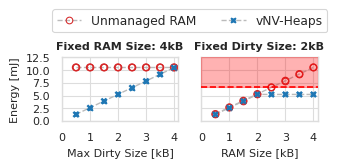

In [207]:
from util import convert
from util.plot import plot_lines, save_plot
import matplotlib.pyplot as plt

axes = plot_lines([options1, options2])

offset_multiplier = 0.2
scaled = convert.scale_data(scaled_dataset[(scaled_dataset["benchmark_id"] == "max_dirty_persist_latency_buffer_size") & (scaled_dataset["options.buffer_size"] % scale == 0)], unit)
#line = scaled["mean"].max() + scaled["mean"].max() * offset_multiplier
line = convert.scale_data(scaled_dataset[(scaled_dataset["benchmark_id"] == "persistent_storage_write") & (scaled_dataset["options.object_size"] == 2.5)], scale=unit)["mean"].iloc[0]

limit2 = (convert.scale_data(scaled_dataset[(scaled_dataset["benchmark_id"] == "persistent_storage_write") & (scaled_dataset["options.object_size"] <= limit)], unit))["mean"].max()
limit2 = 12.5

axes[1].axhline(line, ls='--', color="red", zorder=20)
axes[1].set_ylim(bottom=0, top=limit2)
axes[1].axhspan(line, limit2, alpha=0.3, color="red",zorder=10)
axes[0].legend(
    loc = "lower center",
    bbox_to_anchor=(1.1, 1.3),
    ncol=2,
    title=None,
    frameon=True
)
axes[1].get_legend().remove()

for ax in axes:
    ax.set_xticks([0,1,2,3,4])
    ax.set_xlim(0,4.15)
    ax.set_yticks([0,2.5,5,7.5,10,12.5])

save_plot("persist", False)